In [9]:
!nvidia-smi

Sat Sep  7 08:32:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!pip install -U datasets

In [2]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score


In [3]:
from datasets import load_metric
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/wikiHow.csv')
df.head()

,title,heading,paragraph
0,3 Ways to Finish and Protect Diamond Art,Confirm that all of the diamonds are in the ri...,"Onceyousealthepainting,youwontbeabletomoveanyo..."
1,3 Ways to Finish and Protect Diamond Art,Press all of the diamonds down with a roller.,"Ifthediamondsarentallcompletelyflat,youllgetan..."
2,3 Ways to Finish and Protect Diamond Art,Pick any hair or lint off the painting.,"Ifanyhairorlintgetsstuckunderthesealer,itcould..."
3,3 Ways to Finish and Protect Diamond Art,Wipe the painting with a cloth or toothbrush t...,Begentleandwipetheentirepainting.Thisshouldget...
4,3 Ways to Finish and Protect Diamond Art,Choose a waterproof paint sealer to protect th...,Youhaveafewchoicesforthetypeofsealertouse.Anyt...


to deal with the data duplicates

In [4]:
print(df.shape)
df=df.dropna()
print(df.shape)

(40673, 3)
(40108, 3)


In [5]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)

(40108, 3)
(34725, 3)


to deal with data outliers (data length is too low or too high)

In [6]:
df['length']=df.paragraph.map(lambda x: len(x.split(" ")))

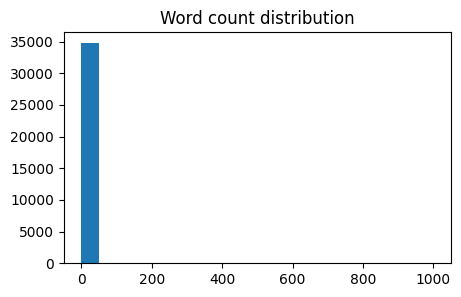

In [7]:
numofwords=df.length
from matplotlib import pyplot as plt

fig = plt.figure(figsize =(5, 3))
plt.hist(numofwords.to_numpy(),bins =[0,50,100,200,300,500,1000])
plt.title("Word count distribution")
plt.show()

In [8]:
# remove the outliers

tempDf=df[df.length<=200]
print(tempDf.shape)

(34725, 4)


In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [34]:
max_input_length = 1024
max_output_length = 64
Batch_size = 16

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["heading"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [1 for _ in range(len(batch["input_ids"][0]))]
    ]
    batch["global_attention_mask"][0][0]=1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
       [-100 if token == tokenizer.pad_token_id else token for token in labels]
       for labels in batch["labels"]
    ]
    return batch

In [35]:
import numpy as np
train, validate,test = np.split(tempDf.sample(frac=1, random_state=42), [int(.6*len(tempDf)), int(.8*len(tempDf))])
print(train.shape)
print(validate.shape)
print(test.shape)

(20835, 4)
(6945, 4)
(6945, 4)


In [36]:
validate = validate[:20]

In [37]:
validate.shape

(20, 4)

In [38]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
validate_dataset = Dataset.from_pandas(validate)


In [39]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=Batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)


Map:   0%|          | 0/20835 [00:00<?, ? examples/s]

In [40]:
val_dataset = validate_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=Batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [41]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [43]:
from transformers import AutoModelForSeq2SeqLM
led=AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384",gradient_checkpointing=True)
led.config.num_beams=2
led.config.max_length=64
led.config.min_length=2
led.config.length_penalty=2.0
led.config.no_repeat_ngram_size=3
led.config.early_stopping=True
rouge =load_metric("rouge")


def compute_metrics(pred):
    labels_ids=pred.label_ids
    pred_ids=pred.predictions

    pred_str=tokenizer.batch_decode(pred_ids,skip_special_tokens=True)
    labels_ids[labels_ids==-100]=tokenizer.pad_token_id
    label_str=tokenizer.batch_decode(labels_ids,skip_special_tokens=True)

    rouge_output=rouge.compute(predictions=pred_str,references=label_str,rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import transformers
transformers.logging.set_verbosity_error()

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=Batch_size,
    per_device_eval_batch_size=Batch_size,

    output_dir="./",
    logging_steps=5,
    save_steps=10,
    eval_steps=10,
    save_total_limit=2,

    gradient_accumulation_steps=4,
    num_train_epochs=10
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

In [44]:
trainer=Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [45]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20835
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 3250
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two vari

{'loss': 3.8573, 'learning_rate': 4.992307692307693e-05, 'epoch': 0.02}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16


{'loss': 2.8011, 'learning_rate': 4.984615384615385e-05, 'epoch': 0.03}


Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json


{'eval_loss': 2.6029696464538574, 'eval_rouge2_precision': 0.05, 'eval_rouge2_recall': 0.025, 'eval_rouge2_fmeasure': 0.0294, 'eval_runtime': 5.2416, 'eval_samples_per_second': 3.816, 'eval_steps_per_second': 0.382, 'epoch': 0.03}


Model weights saved in ./checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./checkpoint-10/tokenizer_config.json
Special tokens file saved in ./checkpoint-10/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 2.7318, 'learning_rate': 4.9769230769230775e-05, 'epoch': 0.05}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16


{'loss': 2.6191, 'learning_rate': 4.969230769230769e-05, 'epoch': 0.06}


Saving model checkpoint to ./checkpoint-20
Configuration saved in ./checkpoint-20/config.json


{'eval_loss': 2.4314966201782227, 'eval_rouge2_precision': 0.0682, 'eval_rouge2_recall': 0.0437, 'eval_rouge2_fmeasure': 0.0521, 'eval_runtime': 5.37, 'eval_samples_per_second': 3.724, 'eval_steps_per_second': 0.372, 'epoch': 0.06}


Model weights saved in ./checkpoint-20/pytorch_model.bin
tokenizer config file saved in ./checkpoint-20/tokenizer_config.json
Special tokens file saved in ./checkpoint-20/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 2.5944, 'learning_rate': 4.961538461538462e-05, 'epoch': 0.08}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16


{'loss': 2.5751, 'learning_rate': 4.953846153846154e-05, 'epoch': 0.09}


Saving model checkpoint to ./checkpoint-30
Configuration saved in ./checkpoint-30/config.json


{'eval_loss': 2.4237678050994873, 'eval_rouge2_precision': 0.03, 'eval_rouge2_recall': 0.0193, 'eval_rouge2_fmeasure': 0.0226, 'eval_runtime': 4.4997, 'eval_samples_per_second': 4.445, 'eval_steps_per_second': 0.444, 'epoch': 0.09}


Model weights saved in ./checkpoint-30/pytorch_model.bin
tokenizer config file saved in ./checkpoint-30/tokenizer_config.json
Special tokens file saved in ./checkpoint-30/special_tokens_map.json
Deleting older checkpoint [checkpoint-10] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autoca

{'loss': 2.3862, 'learning_rate': 4.9461538461538466e-05, 'epoch': 0.11}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16


{'loss': 2.5344, 'learning_rate': 4.9384615384615384e-05, 'epoch': 0.12}


Saving model checkpoint to ./checkpoint-40
Configuration saved in ./checkpoint-40/config.json


{'eval_loss': 2.326125144958496, 'eval_rouge2_precision': 0.055, 'eval_rouge2_recall': 0.055, 'eval_rouge2_fmeasure': 0.0514, 'eval_runtime': 4.7133, 'eval_samples_per_second': 4.243, 'eval_steps_per_second': 0.424, 'epoch': 0.12}


Model weights saved in ./checkpoint-40/pytorch_model.bin
tokenizer config file saved in ./checkpoint-40/tokenizer_config.json
Special tokens file saved in ./checkpoint-40/special_tokens_map.json
Deleting older checkpoint [checkpoint-20] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autoca

{'loss': 2.4989, 'learning_rate': 4.930769230769231e-05, 'epoch': 0.14}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16


{'loss': 2.4772, 'learning_rate': 4.923076923076924e-05, 'epoch': 0.15}


Saving model checkpoint to ./checkpoint-50
Configuration saved in ./checkpoint-50/config.json


{'eval_loss': 2.3291194438934326, 'eval_rouge2_precision': 0.0433, 'eval_rouge2_recall': 0.0383, 'eval_rouge2_fmeasure': 0.0396, 'eval_runtime': 4.5291, 'eval_samples_per_second': 4.416, 'eval_steps_per_second': 0.442, 'epoch': 0.15}


Model weights saved in ./checkpoint-50/pytorch_model.bin
tokenizer config file saved in ./checkpoint-50/tokenizer_config.json
Special tokens file saved in ./checkpoint-50/special_tokens_map.json
Deleting older checkpoint [checkpoint-30] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autoca

{'loss': 2.4841, 'learning_rate': 4.9153846153846157e-05, 'epoch': 0.17}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16


{'loss': 2.4999, 'learning_rate': 4.907692307692308e-05, 'epoch': 0.18}


Saving model checkpoint to ./checkpoint-60
Configuration saved in ./checkpoint-60/config.json


{'eval_loss': 2.3405508995056152, 'eval_rouge2_precision': 0.0342, 'eval_rouge2_recall': 0.0425, 'eval_rouge2_fmeasure': 0.0359, 'eval_runtime': 4.6642, 'eval_samples_per_second': 4.288, 'eval_steps_per_second': 0.429, 'epoch': 0.18}


Model weights saved in ./checkpoint-60/pytorch_model.bin
tokenizer config file saved in ./checkpoint-60/tokenizer_config.json
Special tokens file saved in ./checkpoint-60/special_tokens_map.json
Deleting older checkpoint [checkpoint-40] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autoca

{'loss': 2.5249, 'learning_rate': 4.9e-05, 'epoch': 0.2}


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16


{'loss': 2.4629, 'learning_rate': 4.892307692307693e-05, 'epoch': 0.21}


Saving model checkpoint to ./checkpoint-70
Configuration saved in ./checkpoint-70/config.json


{'eval_loss': 2.31514310836792, 'eval_rouge2_precision': 0.035, 'eval_rouge2_recall': 0.0292, 'eval_rouge2_fmeasure': 0.028, 'eval_runtime': 4.5141, 'eval_samples_per_second': 4.431, 'eval_steps_per_second': 0.443, 'epoch': 0.21}


Model weights saved in ./checkpoint-70/pytorch_model.bin
tokenizer config file saved in ./checkpoint-70/tokenizer_config.json
Special tokens file saved in ./checkpoint-70/special_tokens_map.json
Deleting older checkpoint [checkpoint-50] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autoca

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.28 GiB is free. Process 47213 has 13.46 GiB memory in use. Of the allocated memory 8.11 GiB is allocated by PyTorch, and 5.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [46]:
import pandas as pd
sample_paragraph ="the reason why i loved the top down culture at apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +!0 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to kook up to to help guide decisins is time-saving, it helps us focus on the desing craft instead of project management"
data=[sample_paragraph]
df=pd.DataFrame(data,columns=['paragraph'])
df['paragraph'][0]

from datasets import Dataset
df_test = Dataset.from_pandas(df)

df_test

Dataset({
    features: ['paragraph'],
    num_rows: 1
})

In [54]:
from datasets import load_metric
import torch

from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-60")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-70").to(device).half()
def generate_answer(batch):
    inputs_dict = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )
    input_ids = inputs_dict.input_ids.to(device)
    attention_mask = inputs_dict.attention_mask.to(device)
    global_attention_mask = torch.zeros_like(attention_mask)

    predicated_abstract_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        global_attention_mask=global_attention_mask)
    batch["generated_heading"] = tokenizer.batch_decode(
        predicated_abstract_ids, skip_special_tokens=True
    )
    return batch

result =df_test.map(generate_answer, batched=True, batch_size=2)




Didn't find file /content/checkpoint-60/added_tokens.json. We won't load it.
loading file /content/checkpoint-60/vocab.json
loading file /content/checkpoint-60/merges.txt
loading file None
loading file /content/checkpoint-60/special_tokens_map.json
loading file /content/checkpoint-60/tokenizer_config.json
loading configuration file /content/checkpoint-70/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [55]:
result["generated_heading"]

['Have a leader who can help you with your decisions.']